In [1]:
# =================================================================
# STEP 1: Instalación de dependencias
# =================================================================

import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.morphology import skeletonize, remove_small_objects
from scipy.spatial import distance


In [2]:
# =================================================================
# STEP 2: Configuración de Rutas
# =================================================================

PROJECT_ROOT = Path("..").resolve()
DEPTH_ANYTHING_ROOT = PROJECT_ROOT / "Depth-Anything-V2-main"
CHECKPOINT_PATH = DEPTH_ANYTHING_ROOT / "checkpoints" / "depth_anything_v2_vitl.pth"
YOLO_MODEL_PATH = PROJECT_ROOT / "runs" / "sarmientos_individuales2" / "weights" / "best.pt"

sys.path.append(str(DEPTH_ANYTHING_ROOT))
from depth_anything_v2.dpt import DepthAnythingV2
from depth_anything_v2.util.transform import (
    Resize,
    NormalizeImage,
    PrepareForNet
)
from torchvision.transforms import Compose

device = 'cuda' if torch.cuda.is_available() else 'cpu'

xFormers not available
xFormers not available


In [3]:
# =================================================================
# STEP 3: Carga de Modelos
# =================================================================
# YOLO
from ultralytics import YOLO
yolo_model = YOLO(str(YOLO_MODEL_PATH))

# Depth-Anything-V2
model_configs = {'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}}
depth_model = DepthAnythingV2(**model_configs['vitl'])
depth_model.load_state_dict(torch.load(str(CHECKPOINT_PATH), map_location='cpu'))
depth_model.to(device).eval()

# Transformaciones Depth
depth_transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method="lower_bound",
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406],
                   std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])

def pixel_to_3d_simulated(u, v, depth_map, W, H):
    """
    Simula la proyección 3D de una RealSense.
    u, v: Coordenadas del píxel (X, Y)
    depth_map: Mapa de profundidad reescalado (0-255 o metros)
    """
    # 1. Definir intrínsecos estándar (Basados en RealSense D435)
    focal_length = 600  # Aproximación en píxeles
    cx, cy = W / 2, H / 2
    
    # 2. Obtener profundidad
    # Depth-Anything da valores relativos. 
    # Para la tesis, supongamos que el sarmiento está a 1 metro (valor 255 -> 1.0m)
    depth_val = depth_map[int(v), int(u)]
    
    # Convertimos el valor de la máscara a metros (Simulación métrica)
    # Si mapa es 0-255, esto escala la profundidad entre 0.5m y 1.5m
    z_metros = 0.5 + (depth_val / 255.0) 
    
    # 3. Fórmulas de Proyección (Deproyección)
    x_metros = (u - cx) * z_metros / focal_length
    y_metros = (v - cy) * z_metros / focal_length
    
    return x_metros, y_metros, z_metros

C:\Users\Diego\AppData\Local\Temp\ipykernel_28496\3059684664.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  depth_model.load_state_dict(torch.load(str(CHECKPOINT_PATH)

In [4]:
# =================================================================
# STEP 4: Función Maestra de Estimación (Esqueletización + Eje)
# =================================================================
def estimate_curved_pruning_point(bbox, depth_map, k=1.5):
    x1, y1, x2, y2 = map(int, bbox)
    roi_raw = depth_map[y1:y2, x1:x2].copy()
    if roi_raw.size == 0: return None, None, 0

    # 1. PREPARACIÓN AGRESIVA
    roi_raw = cv2.GaussianBlur(roi_raw, (5, 5), 0)
    roi_depth = cv2.normalize(roi_raw, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # 2. SEGMENTACIÓN (Separar sarmiento de otros objetos)
    # Usamos OTSU pero nos aseguramos de que no sea ruido
    _, mask = cv2.threshold(roi_depth, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Limpieza: Solo el objeto más grande
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels < 2: return None, None, 0
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    mask = (labels == largest_label).astype(np.uint8) * 255

    # 3. ESQUELETIZACIÓN
    skeleton = skeletonize(mask > 0)
    y_coords, x_coords = np.where(skeleton)
    if len(y_coords) < 10: return None, None, 0

    # 4. ORDENAMIENTO DE ABAJO HACIA ARRIBA (Corregido)
    pts = np.column_stack((x_coords, y_coords))
    
    # MEJORA: El inicio es el punto del esqueleto más cercano a la parte INFERIOR de la caja
    # ROI_HEIGHT es y2 - y1. Buscamos el punto con Y más cercano a ese valor.
    roi_h = y2 - y1
    dist_al_suelo = [abs(roi_h - p[1]) for p in pts]
    start_idx = np.argmin(dist_al_suelo)
    
    ordered_pts = []
    actual_pts = pts.tolist()
    current_pt = actual_pts.pop(start_idx)
    ordered_pts.append(current_pt)
    
    while actual_pts:
        dists = distance.cdist([current_pt], actual_pts)[0]
        next_idx = np.argmin(dists)
        
        # Filtro de continuidad: si salta más de 15px, ignoramos el resto (evita unir sarmientos)
        if dists[next_idx] > 15: break
            
        current_pt = actual_pts.pop(next_idx)
        ordered_pts.append(current_pt)
    
    ordered_pts = np.array(ordered_pts)

    # 5. CÁLCULO DE DIÁMETRO Y CORTE
    # Diámetro estable: área / longitud
    diameter = np.sum(mask > 0) / len(ordered_pts)
    target_dist = diameter * k
    
    dist_acc = 0
    idx_cut = 0
    for i in range(1, len(ordered_pts)):
        dist_acc += np.linalg.norm(ordered_pts[i] - ordered_pts[i-1])
        if dist_acc >= target_dist:
            idx_cut = i
            break
    
    # Seguridad: Si no hay suficientes puntos, ponemos el corte al inicio
    if idx_cut == 0: idx_cut = min(len(ordered_pts)-1, 2)
            
    # OFFSET FINAL
    final_point = (int(ordered_pts[idx_cut][0] + x1), int(ordered_pts[idx_cut][1] + y1))
    path = ordered_pts + [x1, y1]
    
    return final_point, path, diameter

In [5]:
# =================================================================
# STEP 5: Ejecución y Visualización
# =================================================================
img_path = list((PROJECT_ROOT / "data" / "processed" / "yolo_dataset" / "images" / "val").glob("*.jpeg"))[5]
raw_img = cv2.imread(str(img_path))
h, w = raw_img.shape[:2]
img_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# Inferencia de Profundidad
img_depth = img_rgb.astype(np.float32) / 255.0
img_depth = depth_transform({"image": img_depth})["image"]
img_depth = torch.from_numpy(img_depth).unsqueeze(0).to(device)

with torch.no_grad():
    depth_pred = depth_model(img_depth)

# Extraer y reescalar al tamaño ORIGINAL (w, h)
depth = depth_pred.squeeze().cpu().numpy() # Squeeze para quitar dimensiones extra
depth_resized = cv2.resize(depth, (w, h), interpolation=cv2.INTER_LINEAR)

# YOLO
results = yolo_model.predict(source=raw_img, conf=0.5, save=False)
img_vis = raw_img.copy()

#  Procesar cada sarmiento
for result in results:
    for box in result.boxes:
        # Coordenadas exactas de YOLO en la imagen original
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        
        # 5. LLAMADA A LA ESTIMACIÓN CURVA (Usando depth_resized)
        # Importante: pasamos las coordenadas de la caja para recortar la profundidad
        cut_pt, path, diam = estimate_curved_pruning_point(
            (x1, y1, x2, y2), depth_resized, k=1.5
        )
        
        if cut_pt:
            # Obtener el punto 3D simulado
            u_cut, v_cut = cut_pt
            x_rob, y_rob, z_rob = pixel_to_3d_simulated(u_cut, v_cut, depth_resized, w, h)
            
            # Dibujar en la imagen
            text_3d = f"3D: {x_rob:.2f}, {y_rob:.2f}, {z_rob:.2f} m"
            cv2.putText(img_vis, text_3d, (int(x1), int(y2) + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 6)

            cv2.putText(img_vis, text_3d, (int(x1), int(y2) + 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2)
                        
            print(f"Punto detectado en posición métrica: X={x_rob:.3f}m, Y={y_rob:.3f}m, Z={z_rob:.3f}m")
            
            # DIBUJAR BBOX (Verde) 
            cv2.rectangle(img_vis, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)
            
            # DIBUJAR EJE (Cian)
            if path is not None:
                for i in range(1, len(path)):
                    pt1 = tuple(path[i-1].astype(int))
                    pt2 = tuple(path[i].astype(int))
                    cv2.line(img_vis, pt1, pt2, (255, 255, 0), 2)
            
            # DIBUJAR PUNTO DE CORTE (Rojo)
            cv2.circle(img_vis, cut_pt, 10, (0, 0, 255), -1)
            
            # TEXTO INFORMATIVO
            cv2.putText(img_vis, f"D:{diam:.1f}px", (int(x1), int(y1)-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


0: 480x640 5 sarmientos, 73.3ms
Speed: 96.8ms preprocess, 73.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)
Punto detectado en posición métrica: X=-0.143m, Y=-0.091m, Z=1.113m
Punto detectado en posición métrica: X=-1.890m, Y=-1.222m, Z=1.171m
Punto detectado en posición métrica: X=0.656m, Y=-0.752m, Z=1.210m
Punto detectado en posición métrica: X=1.772m, Y=0.408m, Z=1.149m
Punto detectado en posición métrica: X=-0.773m, Y=-2.152m, Z=1.501m


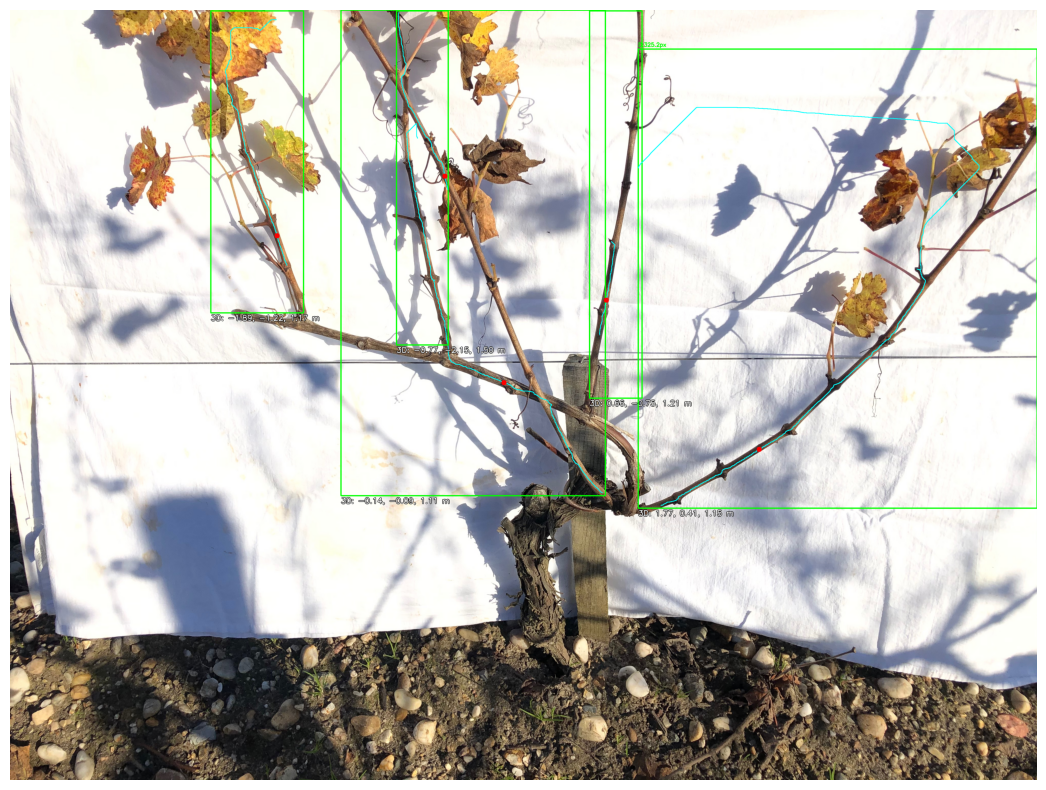

In [6]:
# MOSTRAR RESULTADO
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()